In [312]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [313]:
transactions1 = pd.read_csv("transactions_1.csv", index_col='Unnamed: 0')
transactions2 = pd.read_csv("transactions_2.csv", index_col='Unnamed: 0')
transactions = pd.concat([transactions1, transactions2])

In [314]:
transactions

,customer_id,product_id,date
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z
...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z


In [315]:
transactions['year'] = pd.DatetimeIndex(transactions['date']).year
transactions['month'] = pd.DatetimeIndex(transactions['date']).month
transactions

,customer_id,product_id,date,year,month
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z,2017,1
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z,2017,2
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z,2017,2
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z,2017,2
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z,2017,2
...,...,...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z,2019,5
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z,2017,10
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z,2019,1
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z,2017,3


## Basic Questions
### 1- Create an ordered (descending) plot for the total number of transactions per customer from the most to the least active customer.

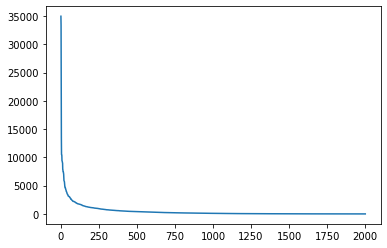

In [316]:
transaction_per_customer = transactions.groupby('customer_id').size()
sorted_trans_per_customer = transaction_per_customer.sort_values(ascending=False)
x = sorted_trans_per_customer.reset_index(drop=True)
plt.plot(x)

### 2- Given any product ID, create a plot to show its transaction frequency per month for the year 2018.

In [317]:
def plot_trans_perMonth(productID, year):
    year_filtered_df = transactions[transactions['year'] == year]
    monthly_bill = year_filtered_df.groupby(['product_id', 'month']).size()
    plt.plot(monthly_bill[productID])

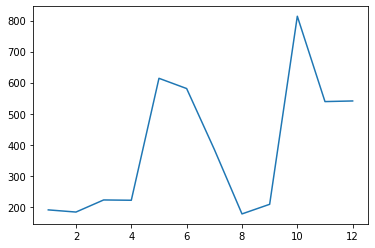

In [318]:
plot_trans_perMonth('ZWL2RHU5YP', 2018)

### 3- At any time, what are the top 5 products that drove the highest sales over the last six months?

In [319]:
def get_last_n_month_highest_sale(n, current_year, current_month):
    tmp_transactions = transactions.copy()
    
    min_year = tmp_transactions['year'].min()
    # create a column of 'number of passed months until now to ease the calculations of past n month transaction history'
    tmp_transactions['acc_month'] = (tmp_transactions['year'] - min_year)*12 + tmp_transactions['month']
    current_acc_month = (current_year - min_year)*12 + current_month
    min_acc_month = (current_year - min_year)*12 + current_month - n + 1
    
    filtered = tmp_transactions[(tmp_transactions['acc_month'] >= min_acc_month)&(tmp_transactions['acc_month']<= current_acc_month)]
    return filtered.groupby('product_id').size().sort_values(ascending=False).head(5)

In [320]:
get_last_n_month_highest_sale(6, 2019, 8)

product_id
5RPSDK28JR    21745
XZ6UVEYK40    10423
VD51ZQPY9D    10204
XD4I34ED7F     9585
G5HEPH9A2T     9267
dtype: int64

### 4- Build a model to predict the total number of expected transactions over the next month for any customer. Split your data appropriately and give enough validation for the performance of your model by simulating the predicted results and comparing with the true values or however you see fit. Keep in mind that sometimes a carefully crafted plot is worth a thousand words.

#### Obviously, this is a time series prediction ML problem and we are dealing with the concept of time, so I search around the internet and found  these links ([1](https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a), [2](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b), and [3](https://www.pluralsight.com/guides/machine-learning-for-time-series-data-in-python)) very helpful and used them to solve this problem.

#### 4-1. Create a proper dataframe which shows us the monthly transactions of each product

In [321]:
def create_monthly_sale_df():
    monthly_trans_df = transactions.copy()
    min_year = monthly_trans_df['year'].min()
    monthly_trans_df['acc_month'] = (monthly_trans_df['year'] - min_year)*12 + monthly_trans_df['month']
    max_month = monthly_trans_df['acc_month'].max()
    monthly_trans_df = monthly_trans_df.drop(columns=['date', 'year', 'month'])
    monthly_trans_df = monthly_trans_df.groupby(['product_id', 'acc_month']).size().to_frame(name = 'count')
    
    monthly_trans_df = monthly_trans_df.pivot_table('count', 'product_id', 'acc_month').fillna(0)
    col_names = monthly_trans.columns
    new_cols_name = ['month_'+str(i) for i in range(1, len(col_names)+1)]
    monthly_trans_df.columns = new_cols_name
    return monthly_trans_df
    

In [324]:
monthly_trans = create_monthly_sale_df()
monthly_trans.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_30,month_31,month_32,month_33,month_34,month_35,month_36,month_37,month_38,month_39
product_id,,,,,,,,,,,,,,,,,,,,,
0A4G5LZWCP,844.0,4147.0,4185.0,2072.0,4949.0,4647.0,3191.0,2967.0,4085.0,5206.0,...,1199.0,1421.0,998.0,936.0,1410.0,1332.0,691.0,791.0,536.0,322.0
0AB7PTAD3X,18.0,131.0,114.0,80.0,401.0,204.0,446.0,164.0,183.0,91.0,...,49.0,148.0,98.0,42.0,142.0,3.0,42.0,16.0,4.0,36.0
0HLIWH0CA1,691.0,1726.0,1940.0,1305.0,2060.0,1821.0,1852.0,1202.0,1233.0,1753.0,...,708.0,764.0,385.0,540.0,754.0,618.0,391.0,300.0,392.0,197.0
0UZVWTQ50H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0W3289OYXV,38.0,175.0,136.0,11.0,2.0,3.0,38.0,61.0,0.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


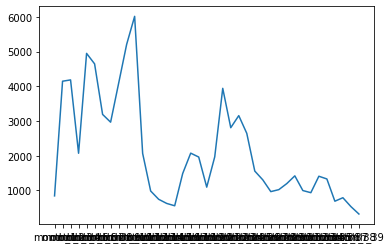

In [325]:
plt.plot(monthly_trans.iloc[0])

### 5- What other interesting questions can be asked about this? For example, do you see a seasonality effect?

In [123]:
transactions['season'] = (transactions['month']-1)//3 + 1
transactions

,customer_id,product_id,date,year,month,season
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z,2017,1,1
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z,2017,2,1
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z,2017,2,1
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z,2017,2,1
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z,2017,2,1
...,...,...,...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z,2019,5,2
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z,2017,10,4
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z,2019,1,1
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z,2017,3,1


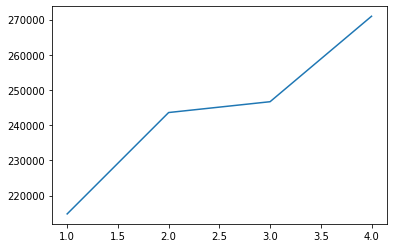

In [124]:
# seasonal transactions
plt.plot(transactions.groupby(['season']).size())

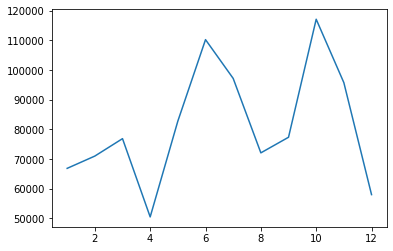

In [125]:
# monthly transactions
plt.plot(transactions.groupby(['month']).size())

<function matplotlib.pyplot.show(close=None, block=None)>

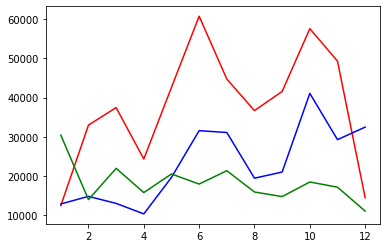

In [18]:
# monthly for each year
plt.plot(transactions[transactions['year'] == 2017].groupby(['month']).size(), color='r')
plt.plot(transactions[transactions['year'] == 2018].groupby(['month']).size(), color='b')
plt.plot(transactions[transactions['year'] == 2019].groupby(['month']).size(), color='g')
# plt.legend()
plt.show

In [ ]:
# monthly overal
plt.plot()